In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/deepfashion2_trousers_subset.zip

In [ ]:
!cp -r /content/content/deepfashion2_trousers_subset /content

In [ ]:
!rm -r /content/content/

# Install Detectron2

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-yvd4rids
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-yvd4rids
  Resolved https://github.com/facebookresearch/detectron2.git to commit 18f69583391e5040043ca4f4bebd2c60f0ebfde0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.8 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6434852 sha256=694654abc9040c95bb8219f99cac2100801b37599d7a01ca882052dee8d6674b
  Stored in directory: /tmp/pip-ephem-wheel-cache-1wquk00f/wheels/17/d9/40/60db98e485aa9455

# Register Dataset

In [ ]:
import os
import random
import cv2
from google.colab.patches import cv2_imshow
import json
import matplotlib.pyplot as plt

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

In [ ]:
train_json = "/content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/coco_format/train_coco.json"
train_img_dir = "/content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/train/image"
val_json = "/content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/coco_format/validation_coco.json"
val_img_dir = "/content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/validation/image"

register_coco_instances("trousers_train", {}, train_json, train_img_dir)
register_coco_instances("trousers_val", {}, val_json, val_img_dir)

# Set keypoint metadata
keypoint_names = [
    "left_waist", "right_waist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
    "crotch", "zipper", "button", "left_thigh", "right_thigh", "bottom_hem"
]
keypoint_flip_map = [
    ("left_waist", "right_waist"), ("left_hip", "right_hip"),
    ("left_knee", "right_knee"), ("left_ankle", "right_ankle"),
    ("left_thigh", "right_thigh")
]

for d in ["trousers_train", "trousers_val"]:
    meta = MetadataCatalog.get(d)
    meta.thing_classes = ["trousers"]
    meta.keypoint_names = keypoint_names
    meta.keypoint_flip_map = keypoint_flip_map
    meta.evaluator_type = "coco"

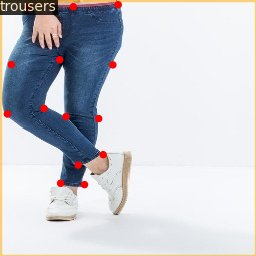

In [ ]:
# Load a sample
dataset_dicts = DatasetCatalog.get("trousers_train")
metadata = MetadataCatalog.get("trousers_train")

# Pick one random image to display
sample = random.choice(dataset_dicts)

# Load the image
img = cv2.imread(sample["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
out = visualizer.draw_dataset_dict(sample)
# Use cv2_imshow instead of cv2.imshow
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("trousers_train",)
cfg.DATASETS.TEST = ("trousers_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Train from scratch (no pretrained weights)
cfg.MODEL.WEIGHTS = ""

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 14

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 100

cfg.OUTPUT_DIR = "/content/deepfashion2_trousers_subset/output_trousers_keypoints"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/17 16:18:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing a

[07/17 16:18:23 d2.utils.events]:  eta: 2:12:37  iter: 19  total_loss: 84.26  loss_cls: 5.476  loss_box_reg: 3.791  loss_keypoint: 66.74  loss_rpn_cls: 0.4101  loss_rpn_loc: 4.298    time: 0.8001  last_time: 0.7720  data_time: 0.0284  last_data_time: 0.0239   lr: 4.9953e-06  max_mem: 3267M
[07/17 16:18:44 d2.utils.events]:  eta: 2:14:36  iter: 39  total_loss: 11.95  loss_cls: 0.2234  loss_box_reg: 0.4758  loss_keypoint: 10.56  loss_rpn_cls: 0.08655  loss_rpn_loc: 0.6776    time: 0.8051  last_time: 0.8047  data_time: 0.0239  last_data_time: 0.0192   lr: 9.9902e-06  max_mem: 3267M
[07/17 16:19:01 d2.utils.events]:  eta: 2:16:48  iter: 59  total_loss: 8.761  loss_cls: 0.1089  loss_box_reg: 0.1828  loss_keypoint: 8.134  loss_rpn_cls: 0.06305  loss_rpn_loc: 0.2424    time: 0.8159  last_time: 0.8978  data_time: 0.0253  last_data_time: 0.0303   lr: 1.4985e-05  max_mem: 3268M
[07/17 16:19:18 d2.utils.events]:  eta: 2:17:15  iter: 79  total_loss: 8.48  loss_cls: 0.1681  loss_box_reg: 0.1679  lo

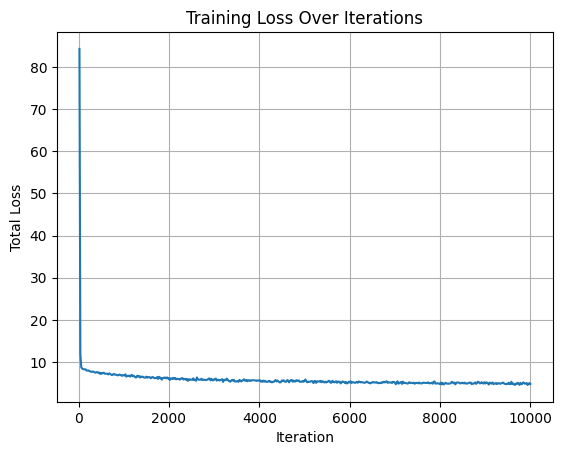

In [ ]:
metrics_path = "/content/deepfashion2_trousers_subset/output_trousers_keypoints/metrics.json"

losses = []
iterations = []

with open(metrics_path, 'r') as f:
    for line in f:
        try:
            data = json.loads(line)
            if "total_loss" in data:
                losses.append(data["total_loss"])
                iterations.append(data["iteration"])
        except:
            continue  # skip malformed lines if any

plt.plot(iterations, losses)
plt.title("Training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.grid(True)
plt.show()

In [ ]:
# Set the final trained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

In [ ]:
# Create evaluator and loader for the validation dataset
evaluator = COCOEvaluator("trousers_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "trousers_val")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
# Run evaluation
predictor = DefaultPredictor(cfg)

# Add 'info' to the ground truth dataset for evaluation
evaluator._coco_api.dataset['info'] = {}

results = inference_on_dataset(predictor.model, val_loader, evaluator)


NameError: name 'evaluator' is not defined

In [ ]:
print("Evaluation results:")
print(metrics)